## Quantile Model - V2 - Training
In this version of the model I will include antecedent flow data along with the Snodas data.

Approach:
Utilize three different linear models: Season Start Snowpack, Season Start Antecedent Flow, Total Seasonal Flow

I will keep the models separate even though they could probably be combined, just for simplicity.

In [1]:
import pandas as pd
from sklearn.linear_model import QuantileRegressor, LinearRegression
from typing import Tuple
import matplotlib.pyplot as plt
import pickle

#### Load datasets

In [2]:
snodas_data = pd.DataFrame()
for year in range(2005,2024):
    year_data = pd.read_csv(f'./data/snodas/snodas_swe_{year}.csv', index_col=0, parse_dates=True)
    snodas_data = pd.concat([snodas_data, year_data])

total_flow = pd.read_csv('./data/competition/train.csv')
monthly_flow = pd.read_csv('./data/competition/train_monthly_naturalized_flow.csv')
metadata = pd.read_csv('./data/competition/metadata.csv')

# Change the column names of the SNODAS data to match the flow data
snodas_data.columns = total_flow['site_id'].unique()

### Generate the snow model from the training data

This model predicts season start snowpack from current snowpack. There is a separate linear model for each prediction date and site.

In [ ]:
# Given a particular date and site, extract the SNODAS data so it can be used to train the linear regression model.
def extract_swe(site: str, day: int, month: int) -> pd.Series:
    # Create a daterange for the given day and month between 2005 and 2023
    input_dates = pd.date_range(start='1/1/2005', end='1/1/2024', freq='D',inclusive='left')
    input_dates = input_dates[(input_dates.day == day) & (input_dates.month == month)]

    # If date is April 1st, change input_dates 2017 value to April 8th since April 1st is missing that year
    if day == 1 and month == 4:
        input_dates = input_dates.drop(pd.to_datetime('2017-04-01'))
        input_dates = input_dates.append(pd.DatetimeIndex(['2017-04-08']))

    snodas_day = snodas_data.loc[input_dates, site]

    # Change the index to be the year
    snodas_day.index = snodas_day.index.year

    # Rename column to swe
    snodas_day.name = 'swe'

    return snodas_day

In [ ]:
# Create a function that generates the model for a given site and date
def generate_snow_model(site: str, day: int, month: int) -> LinearRegression:
    
    # If site is 'pecos_r_nr_pecos' season start date is 3/1, otherwise it is 4/1
    if site == 'pecos_r_nr_pecos':
        season_start_month = 3
    else:
        season_start_month = 4

    # If month is greater than or equal to season start month, the season start date has past, so return None
    if month >= season_start_month:
        return None
    
    # Extract the swe data for the given site and date
    swe_data = extract_swe(site, day, month)

    # Extract season start swe
    season_start_swe = extract_swe(site, 1, season_start_month)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(swe_data.to_numpy().reshape(-1,1), season_start_swe.to_numpy().reshape(-1,1))

    return model

# Test the model at a given site and date
test_model = generate_snow_model('pecos_r_nr_pecos', 1, 2)

In [ ]:
# Check the test snow model
pecos_swe = extract_swe('pecos_r_nr_pecos', 1, 2)
pecos_swe_season_start = extract_swe('pecos_r_nr_pecos', 1, 3)
plt.scatter(pecos_swe, pecos_swe_season_start)
plt.plot(pecos_swe, test_model.predict(pecos_swe.to_numpy().reshape(-1,1)), color='red')

In [ ]:
# Generate the snow models for all sites and dates
snow_models = {}
sites = snodas_data.columns
model_months = [1,2,3,4]
model_days = [1,8,15,22]
model_dates = [(month, day) for month in model_months for day in model_days]

for site in sites:
    snow_models[site] = {}
    for month, day in model_dates:
        snow_models[site][(month, day)] = generate_snow_model(site, day, month)


In [ ]:
# Pickle the snow models for model testing
import pickle
with open('./model/snow_models.pkl', 'wb') as f:
    pickle.dump(snow_models, f)

### Generate the antecedent flow model from the training data
This training dataset is much more extensive than the snow model, however data is limited to months rather than days. At the same time, I found having a different function interface from the snow model makes things really confusing, so I will keep it the same even though many models will be trained on the same data.

In [3]:
# Clean the dataset removing negative values and any incomplete years
monthly_flow_clean = monthly_flow.copy()
monthly_flow_clean.loc[monthly_flow['volume'] < 0, 'volume'] = 0

# First identify what sites/years have missing data
missing_data = monthly_flow[monthly_flow['volume'].isna()].groupby(['site_id','forecast_year']).count().reset_index()

# Next, remove any years with incomplete records from total_flow
merged = monthly_flow_clean.merge(missing_data, on=['site_id', 'forecast_year'], how='left', suffixes=[None,'_merged'], indicator=True)
monthly_flow_clean = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge','year_merged','month_merged','volume_merged'])

In [4]:
# dillon_reservoir_inflow is missing some months from forecast year 1951, remove from dataset
monthly_flow_clean = monthly_flow_clean[~((monthly_flow_clean['site_id'] == 'dillon_reservoir_inflow') & (monthly_flow_clean['forecast_year'] == 1951))]

In [5]:
# Same problem with taylor_park_reservoir_inflow in 1953
monthly_flow_clean = monthly_flow_clean[~((monthly_flow_clean['site_id'] == 'taylor_park_reservoir_inflow') & (monthly_flow_clean['forecast_year'] == 1953))]

In [6]:
# Again at ruedi_reservoir_inflow in 1974
monthly_flow_clean = monthly_flow_clean[~((monthly_flow_clean['site_id'] == 'ruedi_reservoir_inflow') & (monthly_flow_clean['forecast_year'] == 1974))]

In [7]:
# Algorithm to determine months of antecedent flow. The water year starts in October, so antecedent flow for a given month is every month of the water year before that month.
water_year_months = [10,11,12,1,2,3,4,5,6,7,8,9]
def antecedent_months(month: int) -> Tuple[int]:
    return tuple(water_year_months[:water_year_months.index(month)])

In [11]:
# Test antecedent_months
print(antecedent_months(3))

(10, 11, 12, 1, 2)


In [12]:
# Create a function for getting total antecedent flow for a given site and month. Return series of years.
# In order to keep the same interface, I will include a day parameter. So for example, total flow on 2/15 will be total flow for January.
def get_antecedent_flow(site_id: str, day: int, month: int) -> pd.Series:
    site_flow_data: pd.DataFrame = monthly_flow_clean.loc[monthly_flow_clean['site_id'] == site_id,:].copy()
    site_flow_data['antecedent'] = site_flow_data['month'].apply(lambda x: True if x in antecedent_months(month) else False)

    # Calculate total flow where is_runoff is True by site and year
    site_flow_totals = site_flow_data[site_flow_data['antecedent']].groupby(['site_id','forecast_year']).sum().reset_index()

    site_flow_totals.set_index('forecast_year', inplace=True)
    
    return site_flow_totals['volume']

# Test the function at the pecos_r_nr_pecos
test_antecendent = get_antecedent_flow('pecos_r_nr_pecos', 15, 1)

In [14]:
test_antecendent = get_antecedent_flow('dillon_reservoir_inflow', 15, 12)
print(test_antecendent)

forecast_year
1952    10.900
1953     9.500
1954     8.100
1955     8.400
1956    10.400
         ...  
2014    19.980
2016    15.434
2018    16.590
2020    15.044
2022    12.288
Name: volume, Length: 62, dtype: float64


In [15]:
# Create a function for generating a linear regression model for a given site and month
# Similar to the snow model, only generate a model if the season start month has not passed
def generate_flow_model(site_id: str, day: int, month:int) -> LinearRegression:
    # If site is 'pecos_r_nr_pecos' season start date is 3/1, otherwise it is 4/1
    if site_id == 'pecos_r_nr_pecos':
        season_start_month = 3
    else:
        season_start_month = 4

    # If month is greater than or equal to season start month, the season start date has past, so return None
    if month >= season_start_month:
        return None

    # Get the antecedent flow data for the given site and month
    antecedent_flow: pd.Series = get_antecedent_flow(site_id, day, month)

    # Get the season start antecedent flow data for the given site.
    season_start_flow: pd.Series = get_antecedent_flow(site_id, 1, season_start_month)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(antecedent_flow.to_numpy().reshape(-1,1), season_start_flow.to_numpy().reshape(-1,1))

    return model

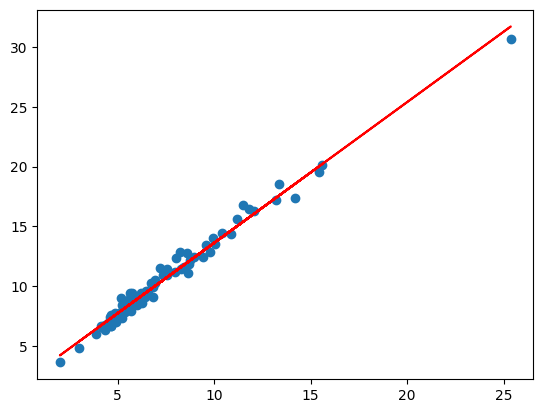

In [16]:
# Test the function at the pecos_r_nr_pecos site for month of 2
pecos_anteflow_model = generate_flow_model('pecos_r_nr_pecos', 15, 1)
pecos_anteflow_jan = get_antecedent_flow('pecos_r_nr_pecos', 15, 1)
pecos_anteflow_ss = get_antecedent_flow('pecos_r_nr_pecos', 1, 3)
plt.scatter(pecos_anteflow_jan, pecos_anteflow_ss)
plt.plot(pecos_anteflow_jan, pecos_anteflow_model.predict(pecos_anteflow_jan.to_numpy().reshape(-1,1)), color='red')

In [17]:
# Check what snodas data columns are not in the monthly_flow data
missing_sites = [site for site in snodas_data.columns if site not in monthly_flow_clean['site_id'].unique()]

In [18]:
# Generate the flow models for all sites and months
antecedent_flow_models = {}
sites = snodas_data.columns
model_months = [1,2,3]
model_days = [1,8,15,22]
model_dates = [(month, day) for month in model_months for day in model_days]

for site in sites:
    print(site)

    # Some sites don't have antecedent flow data, so set them to None
    if site in missing_sites:
        antecedent_flow_models[site] = None
        continue

    antecedent_flow_models[site] = {}
    for month, day in model_dates:
        antecedent_flow_models[site][(month, day)] = generate_flow_model(site, day, month)

hungry_horse_reservoir_inflow
snake_r_nr_heise
pueblo_reservoir_inflow
sweetwater_r_nr_alcova
missouri_r_at_toston
animas_r_at_durango
yampa_r_nr_maybell
libby_reservoir_inflow
boise_r_nr_boise
green_r_bl_howard_a_hanson_dam
taylor_park_reservoir_inflow
dillon_reservoir_inflow
ruedi_reservoir_inflow
fontenelle_reservoir_inflow
weber_r_nr_oakley
san_joaquin_river_millerton_reservoir
merced_river_yosemite_at_pohono_bridge
american_river_folsom_lake
colville_r_at_kettle_falls
stehekin_r_at_stehekin
detroit_lake_inflow
virgin_r_at_virtin
skagit_ross_reservoir
boysen_reservoir_inflow
pecos_r_nr_pecos
owyhee_r_bl_owyhee_dam


In [19]:
# Pickle the antecedent flow models for model testing
with open('./model/antecedent_flow_models.pkl', 'wb') as f:
    pickle.dump(antecedent_flow_models, f)

### Create the final total flow model using Quantile Regression
This model uses season start snowpack and antecedent flow to predict total seasonal flow. There is one model per site and quantile.

For sites without antecedent flow, only the snow model is used.

In [ ]:
# Create a function for generating quatile models for a given site and quantile
def generate_total_flow_model(site_id, quantile) -> QuantileRegressor:
    # If site is 'pecos_r_nr_pecos' season start date is 3/1, otherwise it is 4/1
    if site_id == 'pecos_r_nr_pecos':
        season_start_month = 3
    else:
        season_start_month = 4

    # Get the season start snow data for the given site
    season_start_snow: pd.Series = extract_swe(site_id, 1, season_start_month)

    # Get the season start antecedent flow data for the given site
    season_start_anteflow: pd.Series = get_antecedent_flow(site_id, 1, season_start_month)

    # Create a dataframe with the season start snow and antecedent flow data. Use merge because there will be less years of snow data.
    site_data = pd.merge(season_start_snow, season_start_anteflow, left_index=True, right_index=True)

    # Convert swe to units of kaf
    site_data['swe_kaf'] = site_data['swe'] / 1233.48

    # Get the total flow data for the given site
    site_total_flow = total_flow[total_flow['site_id'] == site_id].drop(columns=['site_id']).set_index('year')

    # Merge the total flow data with the season start data
    site_data = site_data.join(site_total_flow,how='left',lsuffix='_season_start', rsuffix='_total')

    # Create a quantile regression model
    model = QuantileRegressor(quantile=quantile,alpha=0,solver='highs')

    # Fit the model to the data
    model.fit(site_data[['swe_kaf','volume_season_start']], site_data['volume_total'])

    return model

test_model = generate_total_flow_model('pecos_r_nr_pecos', 0.5)

In [ ]:
# Evaluate the model at Pecos
pecos_swe = extract_swe('pecos_r_nr_pecos', 1, 3)
pecos_anteflow = get_antecedent_flow('pecos_r_nr_pecos', 1, 3)
pecos_total_flow = total_flow[total_flow['site_id'] == 'pecos_r_nr_pecos'].drop(columns=['site_id']).set_index('year')
pecos_data = pd.merge(pecos_swe, pecos_anteflow, left_index=True, right_index=True)
pecos_data = pecos_data.join(pecos_total_flow,how='left',lsuffix='_season_start', rsuffix='_total') 
pecos_data['swe_kaf'] = pecos_data['swe'] / 1233.48
pecos_model = generate_total_flow_model('pecos_r_nr_pecos', 0.5)
pecos_data['predicted'] = pecos_model.predict(pecos_data[['swe_kaf','volume_season_start']])

In [ ]:
# Create a second model generator for sites without antecedent flow data that just use swe
# Note that I don't have to worry about pecos with this model because it has antecedent flow data
def generate_total_flow_model_nosnow(site_id, quantile):
    # Get the season start snow data for the given site
    season_start_snow: pd.Series = extract_swe(site_id, 1, 4)

    # Get the total flow data for the given site
    site_total_flow = total_flow[total_flow['site_id'] == site_id].drop(columns=['site_id']).set_index('year')

    # Create a dataframe with season start snow data and total flow data
    site_data = pd.merge(season_start_snow, site_total_flow, left_index=True, right_index=True)
    
    # Convert swe to units of kaf
    site_data['swe_kaf'] = site_data['swe'] / 1233.48

    # Create a quantile regression model
    model = QuantileRegressor(quantile=quantile,alpha=0,solver='highs')

    # Fit the model to the data
    model.fit(site_data[['swe_kaf']], site_data['volume'])

    return model

In [ ]:
# Test the second model generator at merced_river_yosemite_at_pohono_bridge
merced_swe = extract_swe('merced_river_yosemite_at_pohono_bridge', 1, 4)
merced_total_flow = total_flow[total_flow['site_id'] == 'merced_river_yosemite_at_pohono_bridge'].drop(columns=['site_id']).set_index('year')
merced_data = pd.merge(merced_swe, merced_total_flow, left_index=True, right_index=True)
merced_data['swe_kaf'] = merced_data['swe'] / 1233.48

In [ ]:
merced_model = generate_total_flow_model_nosnow('merced_river_yosemite_at_pohono_bridge', 0.5)
merced_data['predicted'] = merced_model.predict(merced_data[['swe_kaf']])

In [ ]:
# Plot merced data
plt.scatter(merced_data['swe_kaf'], merced_data['volume'])
plt.plot(merced_data['swe_kaf'], merced_data['predicted'], color='red')

#### Final model training

In [ ]:
# Generate three different quantile models for each site [0.1, 0.5, 0.9]. At sites without antecedent flow use only the snow model.
quantile_models = {}
quantiles = ['0.1', '0.5', '0.9']

sites = snodas_data.columns

for site in sites:
    quantile_models[site] = {}
    for quantile in quantiles:
        if site in missing_sites:
            quantile_models[site][quantile] = generate_total_flow_model_nosnow(site, float(quantile))
        else:
            quantile_models[site][quantile] = generate_total_flow_model(site, float(quantile))

In [ ]:
import pickle

# Pickle the quantile models for model testing
with open('./model/total_flow_quantile_models.pkl', 'wb') as f:
    pickle.dump(quantile_models, f)